# Part A: Classical Video Classification

**Dataset:** HMDB51 (Walk vs Run)

This notebook implements classical video classification techniques using
hand-crafted features and traditional machine learning algorithms, following
Modules 1–3 of the course.


In [2]:
!pip uninstall -y numpy pandas
!pip install numpy==1.26.4 pandas==2.1.4


Found existing installation: numpy 2.4.2
Uninstalling numpy-2.4.2:
  Successfully uninstalled numpy-2.4.2
Found existing installation: pandas 2.1.4
Uninstalling pandas-2.1.4:
  Successfully uninstalled pandas-2.1.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 50.5 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]2m1/2 [pandas]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [7]:
!pip install scikit-image


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 212.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image] [scikit-image]


In [1]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


## Dataset Description and Organization

A binary subset of the HMDB51 dataset is used for this experiment, consisting
of the following action classes:
- Walk
- Run

Each video is represented as a folder containing extracted RGB frames.
Each folder corresponds to one video instance.


In [2]:
import os

DATASET_PATH = "HMDB51/HMDB51"
CLASSES = ["walk", "run"]

video_folders = []
labels = []

for idx, cls in enumerate(CLASSES):
    class_path = os.path.join(DATASET_PATH, cls)
    for folder in sorted(os.listdir(class_path)):
        full = os.path.join(class_path, folder)
        if os.path.isdir(full):
            video_folders.append(full)
            labels.append(idx)

print("Total videos:", len(video_folders))


Total videos: 780


## Video Loading and Frame Sampling

Videos are loaded as sequences of RGB frames from their respective folders.
Uniform temporal sampling is applied to select a fixed number of frames per
video, enabling consistent feature extraction.


In [3]:
import cv2
import numpy as np

def load_frames_from_folder(folder_path, max_frames=30, size=(320, 240)):
    """
    Load uniformly sampled frames from a folder (HMDB format)
    """
    frame_files = sorted(os.listdir(folder_path))
    
    if len(frame_files) == 0:
        return []

    # Uniform sampling
    indices = np.linspace(
        0, len(frame_files) - 1,
        num=min(max_frames, len(frame_files)),
        dtype=int
    )

    frames = []
    for i in indices:
        img_path = os.path.join(folder_path, frame_files[i])
        frame = cv2.imread(img_path)
        if frame is None:
            continue
        frame = cv2.resize(frame, size)
        frames.append(frame)

    return frames


## Low-Level Feature Extraction

Low-level visual features are extracted from video frames to capture
appearance and texture information. These features are computed at the
frame level and aggregated temporally to form video-level representations.


### Color Features (RGB Histograms)

Color histograms are computed for each RGB channel to capture the overall
color distribution across video frames.


In [4]:
def extract_color_features(frames):
    hist_list = []

    for frame in frames:
        hist_r = cv2.calcHist([frame], [0], None, [32], [0, 256])
        hist_g = cv2.calcHist([frame], [1], None, [32], [0, 256])
        hist_b = cv2.calcHist([frame], [2], None, [32], [0, 256])
        hist = np.concatenate([hist_r, hist_g, hist_b]).flatten()
        hist_list.append(hist)

    return np.mean(hist_list, axis=0)


## Motion Feature Extraction

Motion information is captured using frame differencing between consecutive
frames. Statistical measures of motion intensity are used as motion features.


In [5]:
def extract_motion_features(frames):
    motion_vals = []

    for i in range(1, len(frames)):
        diff = cv2.absdiff(frames[i], frames[i-1])
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        motion_vals.append(np.mean(gray))

    return np.array([
        np.mean(motion_vals),
        np.std(motion_vals)
    ])


In [8]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(frames, P=8, R=1):
    """
    Texture feature using Local Binary Patterns (LBP)
    """
    lbp_features = []

    for frame in frames:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, P, R, method="uniform")
        hist, _ = np.histogram(
            lbp.ravel(),
            bins=np.arange(0, P + 3),
            density=True
        )
        lbp_features.append(hist)

    return np.mean(lbp_features, axis=0)


## Video-Level Feature Representation

Frame-level features are aggregated across time using statistical measures
(mean and standard deviation) to form a single feature vector per video.


In [18]:
X = []
y = []

for folder, label in zip(video_folders, labels):
    frames = load_frames_from_folder(folder)

    if len(frames) < 2:
        continue

    color_feat = extract_color_features(frames)
    motion_feat = extract_motion_features(frames)

    lbp_feat = extract_lbp_features(frames)

    features = np.concatenate([
        color_feat,
        motion_feat,
        lbp_feat
    ])


    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("Feature matrix:", X.shape)
print("Labels:", y.shape)


Feature matrix: (780, 108)
Labels: (780,)


## Classical Machine Learning Models

Multiple classical machine learning algorithms are trained using the extracted
video-level features to perform classification.


## Performance Evaluation

Model performance is evaluated using accuracy, precision, recall, F1-score,
confusion matrices, and ROC–AUC metrics, as required by the assignment.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    "SVM (RBF)": SVC(kernel="rbf"),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds, target_names=CLASSES))



SVM (RBF)
Accuracy: 0.7243589743589743
              precision    recall  f1-score   support

        walk       0.72      0.99      0.84       110
         run       0.80      0.09      0.16        46

    accuracy                           0.72       156
   macro avg       0.76      0.54      0.50       156
weighted avg       0.74      0.72      0.64       156


Random Forest
Accuracy: 0.7692307692307693
              precision    recall  f1-score   support

        walk       0.77      0.96      0.85       110
         run       0.78      0.30      0.44        46

    accuracy                           0.77       156
   macro avg       0.77      0.63      0.65       156
weighted avg       0.77      0.77      0.73       156


Logistic Regression
Accuracy: 0.7692307692307693
              precision    recall  f1-score   support

        walk       0.79      0.92      0.85       110
         run       0.68      0.41      0.51        46

    accuracy                           0.77     

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [21]:
def detailed_evaluation(y_true, y_pred, y_score, model_name):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(CLASSES)), CLASSES)
    plt.yticks(range(len(CLASSES)), CLASSES)

    for i in range(len(CLASSES)):
        for j in range(len(CLASSES)):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.show()

    # ROC Curve (binary)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()
    plt.show()

    print("ROC-AUC:", roc_auc)



SVM (RBF)


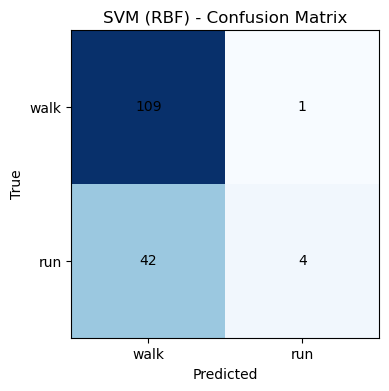

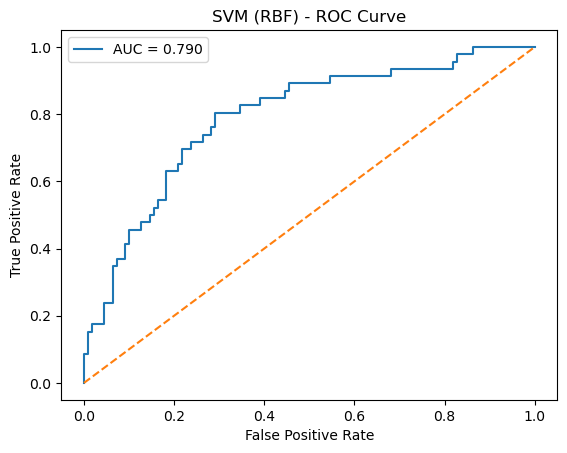

ROC-AUC: 0.7901185770750988

Random Forest


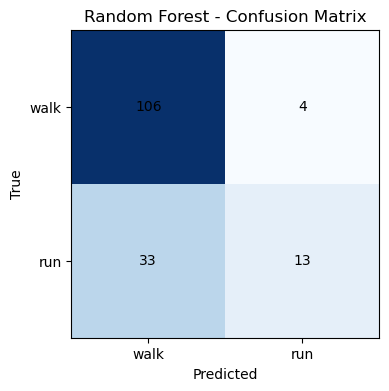

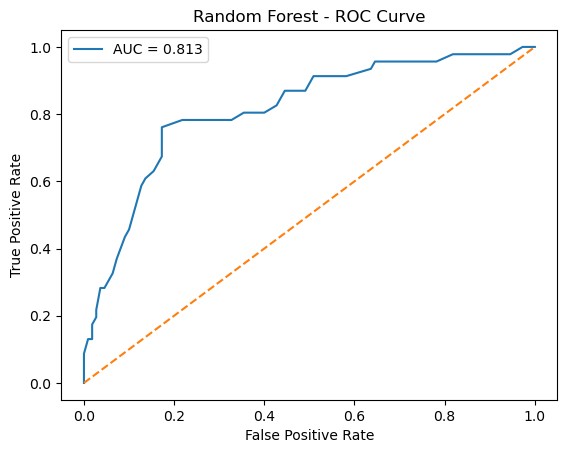

ROC-AUC: 0.8133399209486166

Logistic Regression


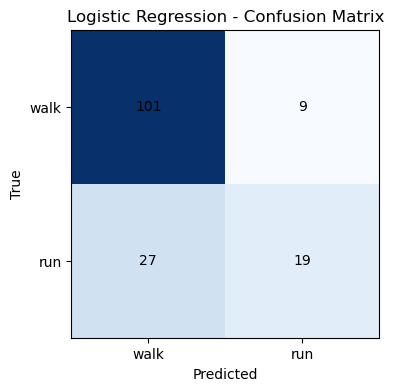

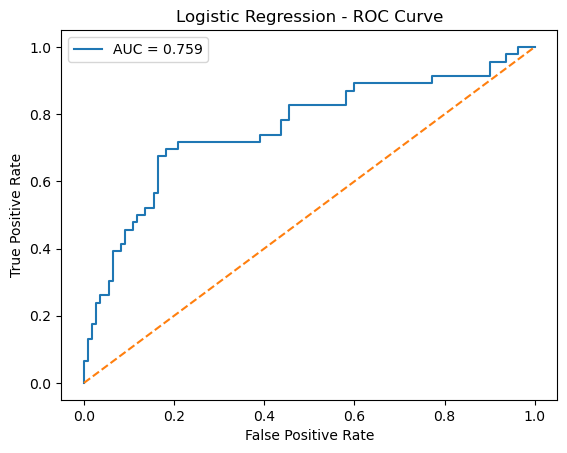

ROC-AUC: 0.758695652173913


In [22]:
for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Score for ROC
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    print(f"\n{name}")
    detailed_evaluation(y_test, y_pred, y_score, name)


## Summary

This notebook demonstrated classical video classification using hand-crafted
features and traditional machine learning algorithms. The results serve as a
baseline for comparison with deep learning approaches explored in Part B.
